# Install & import libraries 📚

In [1]:
import sklearn
from tsai.basics import *
my_setup(sklearn)
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
import mat73
import os
import subprocess
import sys
import tensorflow as tf
import numpy as np
from scipy.linalg import pinv
from scipy.linalg import logm
import pandas as pd

from tsai.optuna import *
import papermill as pm
from tsai.optuna import run_optuna_study
from fastcore.basics import *
from torch.cuda import amp

os              : Windows-10-10.0.19045-SP0
python          : 3.11.4
tsai            : 0.3.9
fastai          : 2.7.17
fastcore        : 1.7.22
sklearn         : 1.3.2
torch           : 2.2.2+cu118
device          : 1 gpu (['NVIDIA GeForce RTX 3090 Ti'])
cpu cores       : 16
threads per cpu : 1
RAM             : 31.75 GB
GPU memory      : [23.99] GB


In [2]:
# Check for GPUs
# Change the CUDA_VISIBLE_DEVICES values to numbers
# See (https://forums.fast.ai/t/exception-occured-in-lrfinder-when-calling-event-after-fit/104389/8)
if torch.cuda.is_available():
    #result = subprocess.check_output("nvidia-smi -L | grep -oE '[0-9]+:' | tr -d ':'", shell=True).decode("utf-8").strip()
    #os.environ['CUDA_VISIBLE_DEVICES'] = result
    #print(os.environ['CUDA_VISIBLE_DEVICES'])
    pass

In [3]:
torch.cuda.is_available()

True

# Model and Data Selection

In [4]:
# Define the available options
data_options = ["NRLMSISE", "TIEGCM"]

# Ask the user to select a data set
print("Please select a data set:")
for i, option in enumerate(data_options, 1):
    print(f"{i}. {option}")
data_choice = int(input("Enter the number of your choice: "))
data_name = data_options[data_choice - 1]

# Use the data_name in your naming path
path = f"data/{data_name}"

Please select a data set:
1. NRLMSISE
2. TIEGCM


#### Choose Training, Validation, and Test Density Data Model

In [5]:
# NRLMSISE
if data_name == 'NRLMSISE':
    df_raw = loadmat('data/Atmospheric Density ROMs/NRLMSISE_1997_2008_ROM_r100.mat')

# TIEGCM
if data_name == 'TIEGCM':
    df_raw = scipy.io.loadmat('data/Atmospheric Density ROMs/TIEGCM_1997_2008_ROM_r100.mat')

In [6]:
# POD Dimension
r=10

# Atmospheric Density Snapshots
X = df_raw["densityDataLogVarROM100"][:r,:];

## Load Scaled Data

In [7]:
# Parameters
freq = '1H'

fcst_history = 24*3*6 # 1/freq*18 (18 days) 432 steps in the past
fcst_horizon = 24*3  # 1/freq*3 (3 days) 72 steps in the future

#### Load Dataset and Splits

In [8]:
# Load dataframes
low_df = load_object('training/training_data/low_df_'+path+'.pkl')
low_df = low_df.reset_index(drop=True)

medium_df = load_object('training/training_data/medium_df_'+path+'.pkl')
medium_df = medium_df.reset_index(drop=True)

high_df = load_object('training/training_data/high_df_'+path+'.pkl')
high_df = high_df.reset_index(drop=True)

# Load splits
low_splits = load_object('training/splits/splits_lowSW_'+path+'.pkl')
medium_splits = load_object('training/splits/splits_mediumSW_'+path+'.pkl')
high_splits = load_object('training/splits/splits_highSW_'+path+'.pkl')

# Low SW
train_split = low_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_lowSW_'+path+'.pkl')
low_df_scaled = exp_pipe.fit_transform(low_df, scaler__idxs=train_split)

# Medium SW
train_split = medium_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_mediumSW_'+path+'.pkl')
medium_df_scaled = exp_pipe.fit_transform(medium_df, scaler__idxs=train_split)

# High SW
train_split = high_splits[0]
exp_pipe = load_object('training/exp_pipe/exp_pipe_highSW_'+path+'.pkl')
high_df_scaled = exp_pipe.fit_transform(high_df, scaler__idxs=train_split)

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.1s
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


### Data

In [9]:
# Define the available options
data_options = ["low space weather", "medium space weather", "high space weather"]

# Ask the user to select a data set
print("Please select a data set:")
for i, option in enumerate(data_options, 1):
    print(f"{i}. {option}")
data_choice = int(input("Enter the number of your choice: "))
training_name = data_options[data_choice - 1]

Please select a data set:
1. low space weather
2. medium space weather
3. high space weather


In [10]:
if training_name == 'low space weather':
    df = low_df
    splits = low_splits
elif training_name == 'medium space weather':
    df = medium_df
    splits = medium_splits
elif training_name == 'high space weather':
    df = high_df
    splits = high_splits
else:
    print("Name not recognized")
    
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [11]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

# Evaluate model 🕵️‍♀️

In [12]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST_'+data_name+'_'+training_name+'.pt')

y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test_preds.shape: (20909, 51, 72)


In [13]:
# Density and SW prediction
y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

,mse,mae
test,0.602701,0.416704


In [14]:
# Atmospheric density only
y_test_preds_density = y_test_preds[:,:10,:]
y_test_density = y[splits[2]][:,:10,:]

In [15]:
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test_density.flatten(), y_test_preds_density.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test_density.flatten(), y_test_preds_density.flatten())
results_df

,mse,mae
test,0.98045,0.691109


In [16]:
df['index'] = range(len(df))

# Fetch the first test dataset date from the DataFrame
start_date = df.iloc[splits[2][0]]['date']
print(start_date)

2006-07-23 19:00:00


In [17]:
import pandas as pd

# Calculate the forecast start index (number of hours from start date to forecast start date)
forecast_start_index = splits[2][0]
print(f"Forecast start index: {forecast_start_index}")

# History and horizon window sizes
history_window = 24*3*6
horizon_window = 24*3

# Calculate the sequence start index by subtracting the history window
sequence_start_index = forecast_start_index - history_window
print(f"Sequence start index: {sequence_start_index}")

Forecast start index: 83779
Sequence start index: 83347


In [18]:
# (number of predictions, first 10 are atmospheric density modes and remaining 41 are space weather indices, forecast horizon)
y_test_preds.shape

(20909, 51, 72)

In [19]:
mse_list = []
density_mode1_list = []
i = 0 # day to start forecast

# Loop over 72 index / 3 day predictions
for j in range(np.shape(y_test_preds)[2]):
    # Recore the MSE for only the atmospheric density modes
    mse_list.append(mean_squared_error(y_test_preds[i, :10, j].flatten(), y_test[i, :10, j].flatten()))
    density_mode1_list.append(float(y_test_preds[i, 0, j].flatten()[0]))

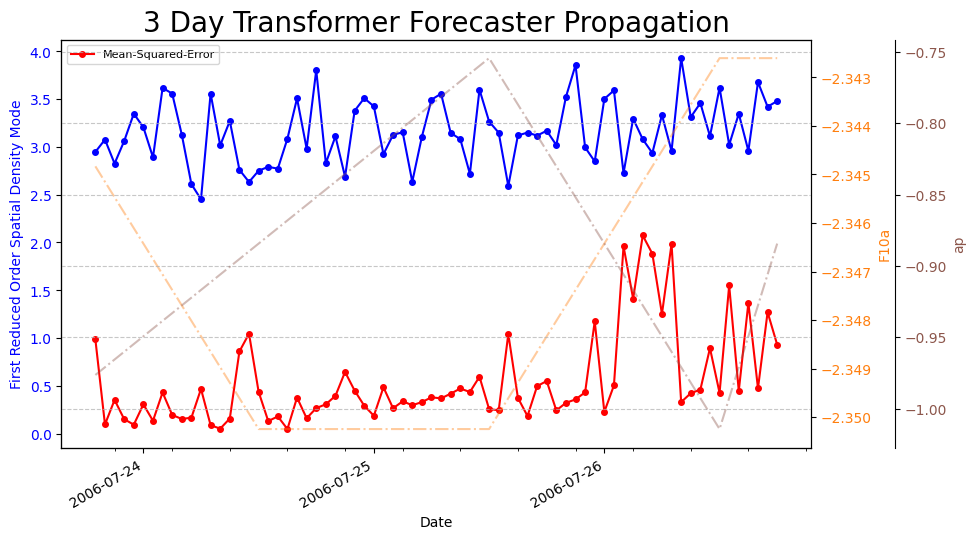

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.dates as mdates

# Create a date range for the x-axis
date_range = pd.date_range(start=start_date, periods=fcst_horizon, freq='H')

length = np.shape(y_test_preds)[2]

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the density data
ax1.plot(date_range[:length], density_mode1_list[:length], marker='o', markersize=4, linestyle='-', linewidth=1.5, color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('First Reduced Order Spatial Density Mode', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot the MSE data
ax1.plot(date_range[:length], mse_list[:length], marker='o', markersize=4, linestyle='-', linewidth=1.5, color='r',label='Mean-Squared-Error')


# Formatting the x-axis
ax1.xaxis.set_major_locator(mdates.DayLocator())  # Major ticks every day
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))  # Minor ticks every 6 hours
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Date format for major ticks
fig.autofmt_xdate()  # Auto-format the x-axis labels for better readability

# Create twin axis for F10a
ax2 = ax1.twinx()
ax2.set_ylabel('F10a', color='tab:orange')
ax2.plot(date_range[:length], df['F10a'].iloc[splits[2][i:fcst_horizon+i]], linestyle='-.', color='tab:orange', alpha=0.4)
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Create another twin axis for Kp
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third y-axis to the right
ax3.set_ylabel('ap', color='tab:brown')
ax3.plot(date_range[:length], df['ap1'].iloc[splits[2][i:fcst_horizon+i]], linestyle='-.', color='tab:brown', alpha=0.4)
ax3.tick_params(axis='y', labelcolor='tab:brown')

# Adding title and grid
plt.title('3 Day Transformer Forecaster Propagation', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Place the legend outside the plot
ax1.legend(loc='upper left', fontsize=8)

# Increase spacing between subplots for legend
plt.subplots_adjust(right=0.75)
